In [238]:
# import libraries
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Show plots in the notebook
%matplotlib inline

In [239]:
#import data
data = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc", engine="netcdf4")
# check data
data

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [240]:
# slice the area needed (5N-5S, 170W-120W)
data = data.sel(lat=slice(-5,5), lon=slice(190, 240))
# check data
data

<xarray.Dataset>
Dimensions:  (lat: 5, lon: 26, time: 684)
Coordinates:
  * lat      (lat) float32 -4.0 -2.0 0.0 2.0 4.0
  * lon      (lon) float32 190.0 192.0 194.0 196.0 ... 234.0 236.0 238.0 240.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [241]:
# check null values
data.isnull().sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sst      int32 0

In [242]:
# calculate the mean of the data according to time
mean_time = data.mean(dim=['lat', 'lon'])
#check mean_time
mean_time

<xarray.Dataset>
Dimensions:  (time: 684)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time) float32 26.25 26.27 26.97 27.51 ... 26.1 25.82 25.72 25.76

In [243]:
# calculate the mean of the data according to month
mean_month = mean_time.groupby('time.month').mean()
# check result
mean_month

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month) float32 26.57 26.74 27.24 27.69 ... 26.74 26.72 26.69 26.61

In [244]:
# find the anomalies
anomalies =mean_time.groupby('time.month') - mean_month
# check result
anomalies

<xarray.Dataset>
Dimensions:  (time: 684)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time) float32 -0.3196 -0.4685 -0.2682 ... -0.8967 -0.9708 -0.8553

In [245]:
# calculate the rolling mean
mean_rolling = anomalies.rolling(time=3, center=True, min_periods=1).mean()
# check result
mean_rolling

<xarray.Dataset>
Dimensions:  (time: 684)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time) float32 -0.3941 -0.3521 -0.3079 ... -0.8358 -0.9076 -0.913

In [246]:
# transform to dataframe to plot, I am inspired by my roommate Zhouzhou
tf = mean_rolling.to_dataframe().reset_index()
anomalies_df = anomalies.to_dataframe().reset_index()
# check  result
tf

,time,month,sst
0,1960-01-15,1,-0.394051
1,1960-02-15,2,-0.352084
2,1960-03-15,3,-0.307880
3,1960-04-15,4,-0.210906
4,1960-05-15,5,-0.240752
...,...,...,...
679,2016-08-15,8,-0.618387
680,2016-09-15,9,-0.728148
681,2016-10-15,10,-0.835824
682,2016-11-15,11,-0.907570


In [247]:
# check result
anomalies_df

,time,month,sst
0,1960-01-15,1,-0.319580
1,1960-02-15,2,-0.468521
2,1960-03-15,3,-0.268152
3,1960-04-15,4,-0.186966
4,1960-05-15,5,-0.177599
...,...,...,...
679,2016-08-15,8,-0.647745
680,2016-09-15,9,-0.640022
681,2016-10-15,10,-0.896675
682,2016-11-15,11,-0.970774


Text(0.5, 0, 'Year')

<Figure size 1200x960 with 0 Axes>

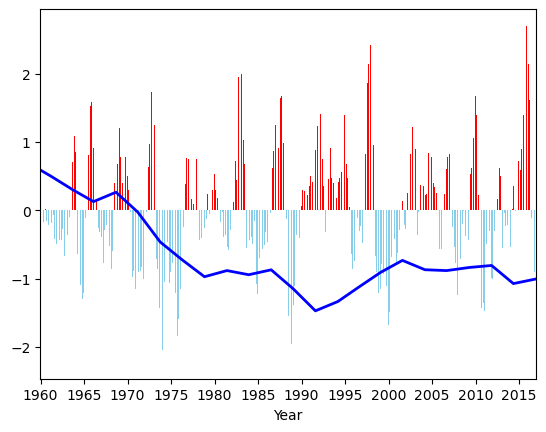

In [254]:
plt.figure(figsize=(10,8), dpi=120) 

# adjust the color
colour = np.where(anomalies_df['sst']>0,'red', 'skyblue')
# plot bar chart
ax = anomalies_df.plot(kind='bar', x='time', y='sst',legend= False, color=colour)
plt.plot(anomalies_df['time'],anomalies_df['sst'], color='blue', linewidth=2)

# adjust the x label
# 5 years a tick 
year_index = anomalies_df['time'].dt.year[::60].index
year = anomalies_df['time'].dt.year[::60]
# set ticks and horizontal axis
ax.set_xticks(ticks=year_index, labels=year, rotation=0)
ax.set_xlabel('Year')



Text(0.5, 0, 'Year')

<Figure size 10000x10000 with 0 Axes>

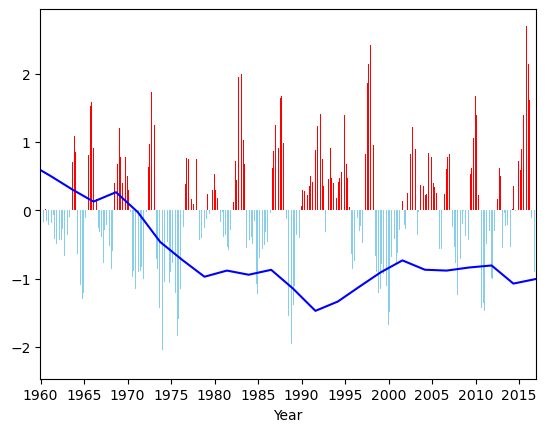

In [255]:
plt.figure(figsize=(10,10), dpi=1000) 

# adjust the color
colour = np.where(anomalies_df['sst']>0,'red', 'skyblue')
# plot bar chart
ax = anomalies_df.plot(kind='bar', x='time', y='sst',legend= False, color=colour)
plt.plot(anomalies_df['time'], anomalies_df['sst'], color='blue')

# adjust the x label
# 5 years a tick 
year_index = anomalies_df['time'].dt.year[::60].index
year = anomalies_df['time'].dt.year[::60]
# set ticks and horizontal axis
ax.set_xticks(ticks=year_index, labels=year, rotation=0)
ax.set_xlabel('Year')


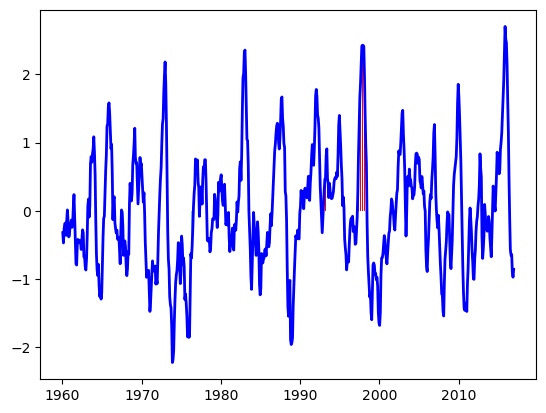

In [257]:
# 绘制柱状图
plt.bar(anomalies_df['time'], anomalies_df['sst'], color=colour)
plt.plot(anomalies_df['time'],anomalies_df['sst'], color='blue', linewidth=2)
# 在同一张图上绘制滑动平均值的线图
